In [23]:
### Import libraries and apply overlay

from enum import Enum
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from pynq import allocate, Overlay

In [24]:
# Download the Resize IP bitstream

resize_design = Overlay("resizer.bit")    
dma = resize_design.axi_dma_0

resizer = resize_design.resize_accel_0

In [25]:
### Download cat images into the folder `cats/`


In [26]:
# image_in, image_out: PIL.Image
# image_out_size: (width, height)
# resize_type: (PL, PS)

class ResizeType(Enum):
    PL = 1
    PS = 2

def fpga_resize(image_in, image_out_size, resize_type):

    # Display the image to be resized
    canvas = plt.gcf()
    size = canvas.get_size_inches()
    canvas.set_size_inches(size)
    old_width, old_height = image_in.size
    
    print("Image size: {}x{} pixels.".format(old_width, old_height))
    _ = plt.imshow(image_in)
    
    # Resizing
    new_width = image_out_size[0]
    new_height = image_out_size[1]
    
    # Display resized image
    if resize_type == ResizeType.PL:
        in_buffer = allocate(shape=(old_height, old_width, 3),
                         dtype=np.uint8, cacheable=1)
        out_buffer = allocate(shape=(new_height, new_width, 3), 
                          dtype=np.uint8, cacheable=1)
        
        in_buffer[:] = np.array(image_in)
        
        def run_kernel():
            dma.sendchannel.transfer(in_buffer)
            dma.recvchannel.transfer(out_buffer)    
            resizer.write(0x00,0x81)
            dma.sendchannel.wait()
            dma.recvchannel.wait()
    
        resizer.write(0x10, old_height)
        resizer.write(0x18, old_width)
        resizer.write(0x20, new_height)
        resizer.write(0x28, new_width)
    
        run_kernel()
        image_out = Image.fromarray(out_buffer)
    
        print("Image size: {}x{} pixels.".format(new_width, new_height))
        _ = plt.imshow(image_out)
        
        del in_buffer
        del out_buffer
    else:
        image_out = image_in.resize((new_width, new_height), Image.BILINEAR)
        
        print("Image size: {}x{} pixels.".format(new_width, new_height))
        _ = plt.imshow(image_out)
    
    return image_out

In [33]:
def fpga_resize_images(image_paths):
    images = []
    for path in image_paths:
        original_image = Image.open(path)
        resized_image = fpga_resize(original_image, (60, 60), ResizeType.PL)
        images.append(resized_image)
        
    return images

In [34]:
def cpu_resize_images(image_paths):
    images = []
    for path in image_paths:
        original_image = Image.open(path)
        resized_image = fpga_resize(original_image, (60, 60), ResizeType.PS)
        images.append(resized_image)
        
    return images

Image size: 1024x576 pixels.
Image size: 60x60 pixels.
Image size: 1024x576 pixels.
Image size: 60x60 pixels.
Image size: 1024x576 pixels.
Image size: 60x60 pixels.
Image size: 1024x576 pixels.
Image size: 60x60 pixels.
Image size: 1024x576 pixels.
Image size: 60x60 pixels.
Image size: 1024x576 pixels.
Image size: 60x60 pixels.
Image size: 1024x576 pixels.
Image size: 60x60 pixels.
Image size: 1024x576 pixels.
Image size: 60x60 pixels.
Image size: 1024x576 pixels.
Image size: 60x60 pixels.
Image size: 1024x576 pixels.
Image size: 60x60 pixels.


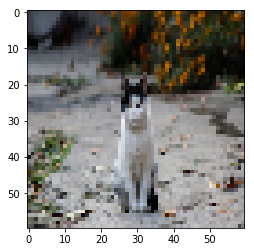

In [37]:
image_paths = !ls cats/*jpg
# cpu_resize_images(image_paths)
result = fpga_resize_images(image_paths)

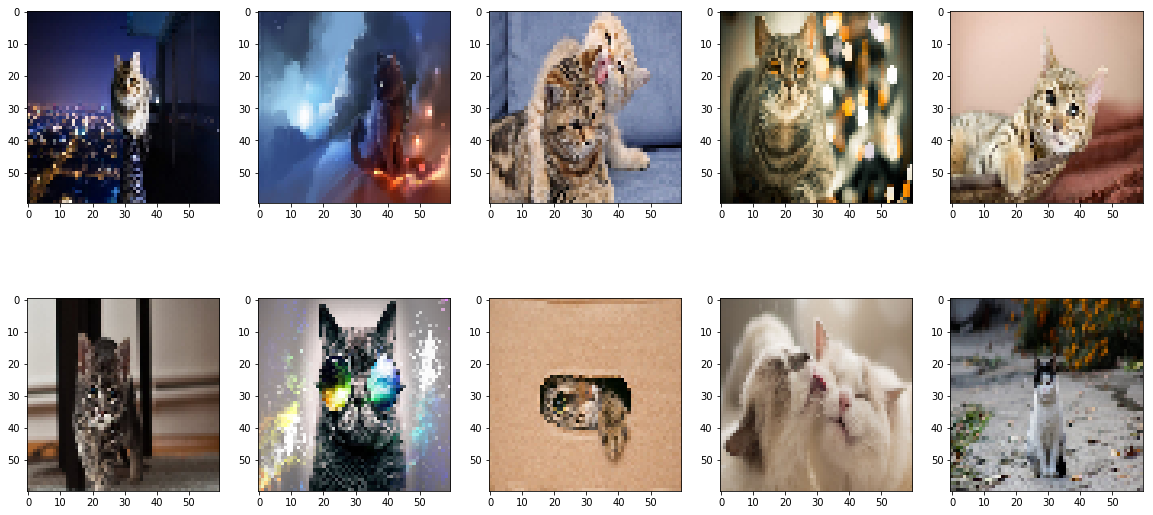

In [44]:
plt.figure(figsize=(20,10))
columns = 5
for i, image in enumerate(result):
    plt.subplot(len(result) / columns + 1, columns, i + 1)
    plt.imshow(image)